In [ ]:
from helperfunctions import *

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

In [ ]:
'''
#################### I: Camera Calibration ###############################

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
'''

In [ ]:


# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [ ]:
print(len(images))

In [ ]:
for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.figure()
        plt.imshow(img)
        
        # this will pop out addidtional window to display !
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        
#cv2.destroyAllWindows()
plt.show()

In [ ]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration10.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

In [ ]:
print(len(camera_calib))

In [ ]:
print(camera_calib["mtx"])

In [ ]:
print(camera_calib["dist"])

In [ ]:
'''
############################ II. image pipleline ############################

2. Apply the distortion correction to the raw image.
'''

In [ ]:


#raw = cv2.imread("test_images/xygrad.jpg")
#raw = cv2.imread("test_images/test2.jpg")
raw = cv2.imread("test_images/straight_lines1.jpg")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
plt.imshow(image)

In [ ]:
'''
3. Use color transforms, gradients, etc., to create a thresholded binary image
'''

In [ ]:
'''
X, Y sobel gradient threshold 
'''
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        derivative = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("Error: orient must be either x or y.")
    
    # 3) Take the absolute value of the derivative or gradient
    abs_derivative = np.absolute(derivative)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # So there are 1s where #s are within our thresholds and 0s otherwise.
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary


In [ ]:
'''
X, Y magnitude of gradient threshold 
'''
def magnitude_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 6) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 7) Return this mask as your binary_output image
    return mag_binary

In [18]:
'''
X, Y direction of gradient threshold 
'''
def direction_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary

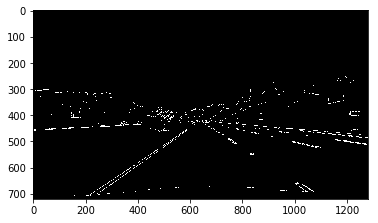

In [19]:


# Choose a Sobel kernel size
ksize = 9 #3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
mag_binary = magnitude_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
dir_binary = direction_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap="gray")
#plt.imshow(combined)

In [20]:
'''
Now it's time to combine color and gradient thresholding reliably
under varying degrees of daylight and shadow.

edges around trees or cars can be mostly filtered out by applying a mask 
to the image and essentially cropping out the area outside of the lane lines.

'''

"\nNow it's time to combine color and gradient thresholding reliably\nunder varying degrees of daylight and shadow.\n\nedges around trees or cars can be mostly filtered out by applying a mask \nto the image and essentially cropping out the area outside of the lane lines.\n\n"

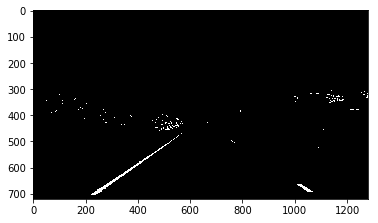

In [21]:
'''
combine sobel X gradient and color S threshold

'''

img = np.copy(image)

# Threshold colour channel

# Convert to HLS colour space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Cont'd: Threshold colour channel
s_thresh_min = 170 #90
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

plt.imshow(s_binary, cmap='gray')
#plt.imshow(s_binary)

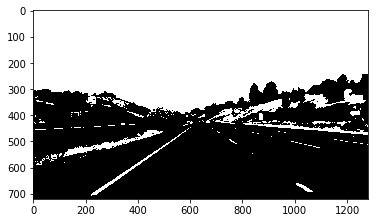

In [22]:
colorimg = np.copy(image)

# Threshold colour channel

# Convert to HLS colour space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(colorimg, cv2.COLOR_BGR2HSV)
s_channel = hls[:,:,2]

# Cont'd: Threshold colour channel
s_thresh_min = 170 #90
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

plt.imshow(s_binary, cmap='gray')
#plt.imshow(s_binary)

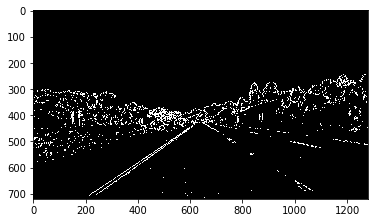

In [23]:
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better


gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

plt.imshow(sxbinary, cmap='gray')
#plt.imshow(sxbinary)

In [24]:
def xgrad_s_threshold(image, xgrad_thresh=(20,100), s_thresh=(170,255)):
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    # Threshold colour channel

    # Convert to HLS colour space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Cont'd: Threshold colour channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

In [25]:
xgrad_thresh_temp = (40,100)
s_thresh_temp=(150,255)

In [26]:


combined_binary = xgrad_s_threshold(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
#plt.imshow(combined_binary, cmap="gray")

In [27]:
'''
 notice !  the difference between cv2.imread VS. mpimg.imread
'''

import matplotlib.image as mpimg


#raw_img = mpimg.imread("test_images/xygrad.jpg")
raw_img = mpimg.imread("test_images/straight_lines1.jpg")


green_blue_image = cv2.undistort(raw_img, mtx, dist, None, mtx)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(green_blue_image)
#plt.imshow(result)

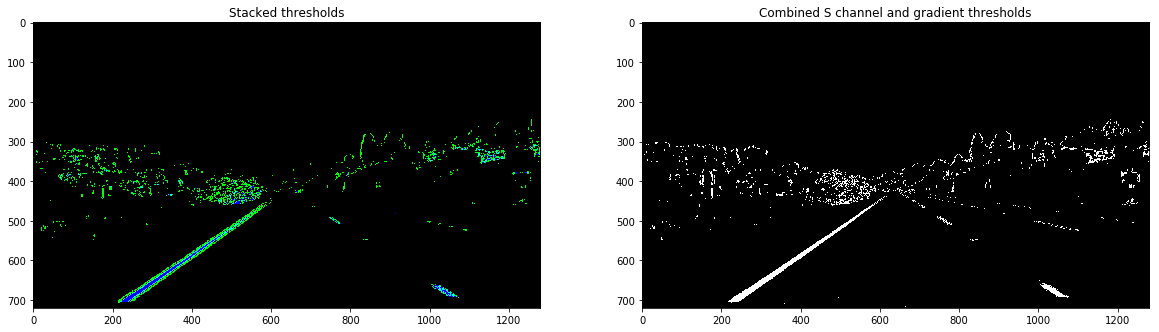

In [28]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(result)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
#ax2.imshow(combined_binary)

In [29]:
'''
above picture, the green component is gradient threshold; 
the blue component is the color channel threshold

'''

'\nabove picture, the green component is gradient threshold; \nthe blue component is the color channel threshold\n\n'

In [30]:
'''
4. perform a perspective transform to get a birds eye view of the curved lane

'''

'\n4. perform a perspective transform to get a birds eye view of the curved lane\n\n'

In [31]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [32]:
imshape = combined_binary.shape
print(imshape)

(720, 1280)


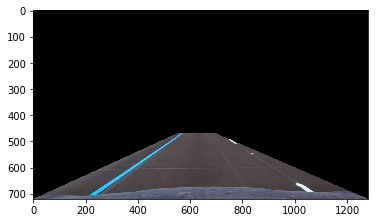

In [33]:
'''
use defined vertices to crop out the region of interest, where 2 lanes left
'''
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)

#masked_image = region_of_interest(combined_binary, vertices)
masked_image = region_of_interest(image, vertices)

plt.imshow(masked_image)

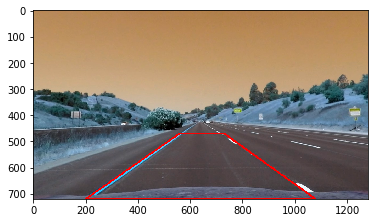

In [34]:
'''
The code for my perspective transform includes a function called warper(), 
which appears in lines 1 through 8 in the file example.py (output_images/examples/example.py)
(or, for example, in the 3rd code cell of the IPython notebook). 
The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. 
I chose the hardcode the source and destination points in the following manner:
'''

sourcepoints_img = np.copy(image)
#plt.imshow(sourcepoints_img)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.set_title('undistorted image with source points drawn')
#ax1.imshow(sourcepoints_img)

#ax2.set_title('Combined S channel and gradient thresholds')
#ax2.imshow(combined_binary, cmap='gray')






top_left = [560, 470]
top_right = [730, 470]
bottom_right = [1080, 720]
bottom_left = [200, 720]
#pts = np.array([bottom_left,bottom_right,top_right,top_left])

cv2.line(sourcepoints_img, tuple(bottom_left), tuple(top_left), (255, 0, 0), 5)
cv2.line(sourcepoints_img, tuple(top_right), tuple(top_left), (255, 0, 0), 5)
cv2.line(sourcepoints_img, tuple(bottom_right), tuple(top_right), (255, 0, 0), 5)
cv2.line(sourcepoints_img, tuple(bottom_left), tuple(bottom_right), (255, 0, 0), 5)

plt.imshow(sourcepoints_img)

## you can plot this and see that lines are properly chosen
#cv2.polylines(img,[pts],True,(255,0,0), 5)
#cv2.polylines(img, np.int32([pts]), 1, (255,255,255))

## cv2.polylines(img,[dst_pts],True,(0,0,255), 5)

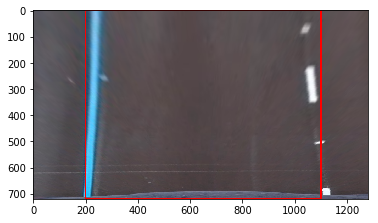

In [35]:
pts = np.array([bottom_left,bottom_right,top_right,top_left])
pts = np.float32(pts.tolist())


top_left_dst = [200,0]
top_right_dst = [1100,0]
bottom_right_dst = [1100,720]
bottom_left_dst = [200,720]

test_src = pts
test_dst = np.array([bottom_left_dst,bottom_right_dst,top_right_dst,top_left_dst])
test_dst = np.float32(test_dst.tolist())

#Compute the perspective transform, M, given source and destination points:
#M = cv2.getPerspectiveTransform(src, dst)
test_M = cv2.getPerspectiveTransform(test_src, test_dst)

#Compute the inverse perspective transform:
test_Minv = cv2.getPerspectiveTransform(test_dst, test_src)

#Warp an image using the perspective transform, M:
test_warped = cv2.warpPerspective(image, test_M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
#warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

cv2.line(test_warped, tuple(bottom_left_dst), tuple(top_left_dst), (255, 0, 0), 5)
cv2.line(test_warped, tuple(top_right_dst), tuple(top_left_dst), (255, 0, 0), 5)
cv2.line(test_warped, tuple(bottom_right_dst), tuple(top_right_dst), (255, 0, 0), 5)
cv2.line(test_warped, tuple(bottom_left_dst), tuple(bottom_right_dst), (255, 0, 0), 5)

plt.imshow(test_warped, cmap="gray")


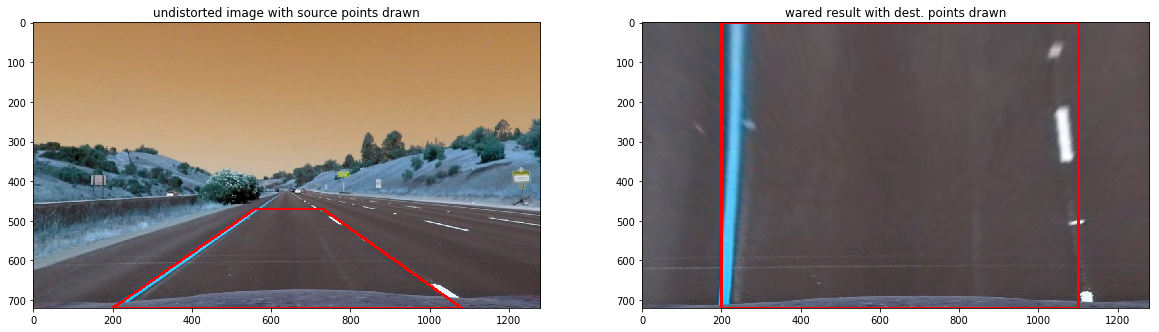

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('undistorted image with source points drawn')
ax1.imshow(sourcepoints_img)

ax2.set_title('wared result with dest. points drawn')
ax2.imshow(test_warped, cmap='gray')

In [37]:
'''
5.identify lane-line pixels and fit their positions with a polynomial
'''

'\n5.identify lane-line pixels and fit their positions with a polynomial\n'

In [38]:
combined_binary_test = xgrad_s_threshold(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)

warped_binay_test = cv2.warpPerspective(combined_binary_test, test_M, (imshape[1], imshape[0]), 
                                         flags=cv2.INTER_LINEAR)

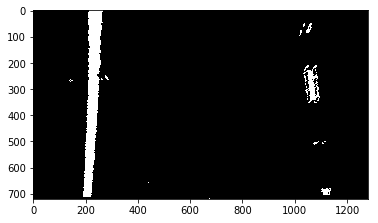

In [39]:
plt.imshow(warped_binay_test, cmap='gray')

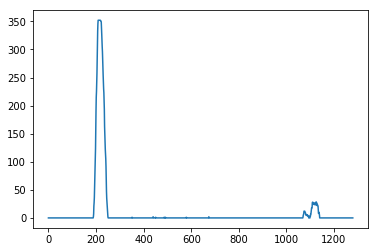

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = np.copy(warped_binay_test)
#print(binary_warped.shape)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)




In [41]:


# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)  #use 28816 points !
right_fit = np.polyfit(righty, rightx, 2)  #use 5929 points !

(720, 0)

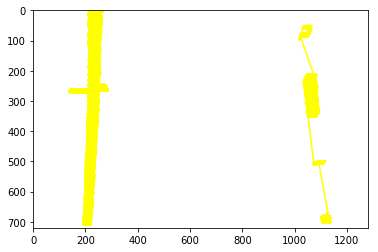

In [42]:
plt.plot(leftx, lefty, color='yellow')
plt.plot(rightx, righty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [43]:
print(leftx.shape, lefty.shape, rightx.shape, righty.shape)

(28816,) (28816,) (5929,) (5929,)


In [44]:
print(left_fit)

[ -4.76818023e-05  -1.03084445e-02   2.37400043e+02]


In [45]:
print(right_fit)

[  7.84592760e-05   6.10895608e-02   1.04072724e+03]


In [46]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#print(ploty) # 0 - 719

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

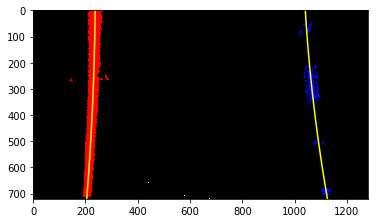

In [47]:
# Generate x and y values for plotting

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

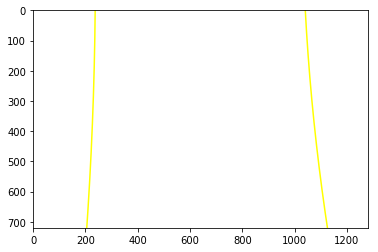

In [48]:
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

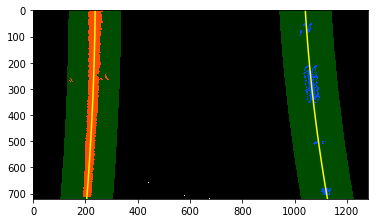

In [49]:


# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [50]:
'''
6. calculated the radius of curvature of the lane and the position of the vehicle with respect to center
'''

'\n6. calculated the radius of curvature of the lane and the position of the vehicle with respect to center\n'

In [51]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad_pixel = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad_pixel = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Left lane curve radius: ", left_curverad_pixel, "pixels")
print("Right lane curve radius: ", right_curverad_pixel, "pixels")

Left lane curve radius:  10584.1885146 pixels
Right lane curve radius:  6664.03338235 pixels


In [52]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

print(left_fit_cr)
print(right_fit_cr)

# Calculate the new radii of curvature
left_curverad_meter = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad_meter = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('at y= ', y_eval, 'left curv is :', left_curverad_meter, 'm', 'right curv is :', right_curverad_meter, 'm')

[ -1.45170653e-04  -1.30769981e-03   1.25482880e+00]
[  2.38874870e-04   7.74964714e-03   5.50098685e+00]
at y=  719.0 left curv is : 3444.7395503 m right curv is : 2094.67450976 m


In [53]:
'''
if instead of using  28816 (leftx, lefty) points and  5929 (rightx, righty) points, 
but only 720 (left_fitx, ploty) points and 720 (right_fitx, ploty) points

--> same reuslt !
'''

'''
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

print(left_fit_cr)
print(right_fit_cr)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
'''


"\nleft_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)\nright_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)\n\nprint(left_fit_cr)\nprint(right_fit_cr)\n# Calculate the new radii of curvature\nleft_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])\nright_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])\n# Now our radius of curvature is in meters\nprint(left_curverad, 'm', right_curverad, 'm')\n"

In [54]:


curvature = (left_curverad_pixel + right_curverad_pixel) / 2
#centre = center(719, left_fit, right_fit)
min_curvature = min(left_curverad_pixel, right_curverad_pixel)
print("mean curvature: ", curvature, "pixels")
#print("centre: ", centre, "pixels")
print("min_curvature: ", min_curvature, "pixels")

mean curvature:  8624.11094847 pixels
min_curvature:  6664.03338235 pixels


In [55]:
# calculate left_min by finding minimum value in first index of array
left_min = np.amin(leftx, axis=0)
print('left_min', left_min)
right_max = np.amax(rightx, axis=0)
print('right max', right_max)
  
actual_center = (right_max + left_min)/2
dist_from_center =  actual_center - (1280/2)
print('pix dist from center', dist_from_center)

meters_from_center = xm_per_pix * dist_from_center
print('meter dist from center', meters_from_center)

string_meters = str(round(meters_from_center, 2))

left_min 136
right max 1139
pix dist from center -2.5
meter dist from center -0.0132142857143


In [56]:
full_text = 'left: ' + str(round(left_curverad_pixel, 2)) + ', right: ' + \
    str(round(right_curverad_pixel, 2)) + ', dist from center: ' + string_meters 
print('full text', full_text)

full text left: 10584.19, right: 6664.03, dist from center: -0.01


In [57]:
'''
7. Plot result back down onto the original road 
such that the lane area is identified clearly
'''

'\n7. Plot result back down onto the original road \nsuch that the lane area is identified clearly\n'

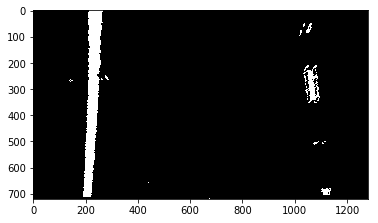

In [58]:
plt.imshow(warped_binay_test, cmap='gray') 

In [59]:
print(left_fitx.shape, ploty.shape)

(720,) (720,)


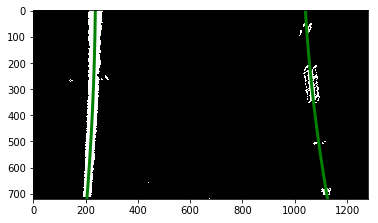

In [60]:

'''
# Histogram and get pixels in window

leftx, lefty, rightx, righty = histogram_pixels(warped_binay_test, horizontal_offset=horizontal_offset)

# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)
'''

# Plot data
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green',linewidth=3)

#plt.plot(left_fit, lefty, color='green', linewidth=3)
#plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped_binay_test, cmap="gray")

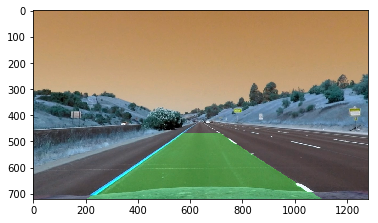

In [61]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_binay_test).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, test_Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image

undist = np.copy(image)
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [62]:
'''
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
'''


'\n8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position\n'

In [63]:
def create_figures_in_image(img, left_curverad_meter, right_curverad_meter, meters_from_center,
                            left_fit=(0,0,0), right_fit=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    # Convert from pixels to meters
    #print(left_curverad_meter, right_curverad_meter, meters_from_center)

    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(img, 'Radius of left Curvature = %d(m)' % left_curverad_meter, (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Radius of right Curvature = %d(m)' % right_curverad_meter, (50, 100), font, 1, (255, 255, 255), 2)
    
    left_or_right = "left" if meters_from_center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(meters_from_center), left_or_right), (50, 150), font, 1,
                (255, 255, 255), 2)
    
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_fit[0], left_fit[1], left_fit[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_fit[0], right_fit[1], right_fit[2]), (50, 250), font, 1, (255, 255, 255), 2)



-0.0132142857143


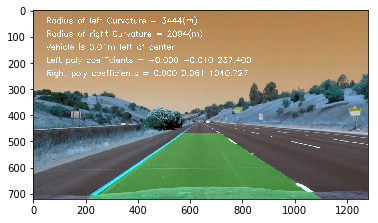

In [64]:
combined_img = np.copy(result)
print(meters_from_center)
create_figures_in_image(combined_img, left_curverad_meter=left_curverad_meter, 
                        right_curverad_meter=right_curverad_meter,
                        meters_from_center=meters_from_center, 
                        left_fit=left_fit,
                        right_fit=right_fit)

plt.imshow(combined_img)

In [65]:
'''
9. summarize a streamlined image pipeline

'''

'\n9. summarize a streamlined image pipeline\n\n'

In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

'''
this 2 global variables may be used, in case between 2 frames coeffs differ exceeds a threshold,
then we will discard new frame but keep coeff from previous frame, to keep the lane we detected
to be stable !!
'''
prev_left_coeffs = None
prev_right_coeffs = None




In [67]:
def create_figures_in_image(img, left_curverad_meter, right_curverad_meter, meters_from_center,
                            left_fit=(0,0,0), right_fit=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    # Convert from pixels to meters
    #print(left_curverad_meter, right_curverad_meter, meters_from_center)

    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(img, 'Radius of left Curvature = %d(m)' % left_curverad_meter, (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Radius of right Curvature = %d(m)' % right_curverad_meter, (50, 100), font, 1, (255, 255, 255), 2)
    
    left_or_right = "left" if meters_from_center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(meters_from_center), left_or_right), (50, 150), font, 1,
                (255, 255, 255), 2)
    
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_fit[0], left_fit[1], left_fit[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_fit[0], right_fit[1], right_fit[2]), (50, 250), font, 1, (255, 255, 255), 2)



In [93]:
def hsv_threshold(img, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    
    return binary_output

In [116]:
'''
from the tested project video clipped frames, it is obvious with only X gradient + S color is not robust enough for
sudden shadowing effects, so need to use also L color threshold in addiditon:

'''


def combo_threshold(image, xgrad_thresh=(20,100), s_thresh=(170,255), l_thresh=(160,240), h_thresh=(190, 250), 
                    hsv_thresh=(50, 255), dir_thresh=(0, np.pi/2), mag_thresh=(30, 100)):
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray)
    #print(gray)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #print(scaled_sobel)

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1
   

    # Threshold colour channel

    # Convert to HLS colour space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    s_channel = hls[:,:,2]
    #print(s_channel)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    
    # Cont'd: Threshold colour channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Cont'd: Threshold colour channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary, h_binary))

    mag_binary = magnitude_thresh(image, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = direction_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)  #0.1, 1.5
    hsv_binary = hsv_threshold(image, thresh=hsv_thresh)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[((s_binary == 1) & (h_binary == 1) & (l_binary == 1) & (hsv_binary == 1) )| (sxbinary == 1) ] = 1

    combined_binary[((s_binary == 1) & (hsv_binary == 1) )| (sxbinary == 1) ] = 1
    
    #print(combined_binary)
    return combined_binary



In [117]:
xgrad_thresh_temp = (40, 100)
s_thresh_temp = (90,255)
h_thresh_temp = (190, 250)
l_thresh_temp = (160, 240)





In [118]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0

In [119]:
def average_pipeline(file, filepath=False):
    global prev_left_fit
    global prev_right_fit
    global prev_left_curverad_pixel
    global prev_right_curverad_pixel
    
    global min_leftx
    global max_leftx
    global min_rightx
    global max_rightx

    global prev_gap_left
    global prev_gap_right
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file
        
    image = cv2.undistort(raw, mtx, dist, None, mtx)


    


    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)


    ########################

    top_left = [560, 470]
    top_right = [730, 470]
    bottom_right = [1080, 720]
    bottom_left = [200, 720]


    pts = np.array([bottom_left,bottom_right,top_right,top_left])
    pts = np.float32(pts.tolist())


    top_left_dst = [200,0]
    top_right_dst = [1100,0]
    bottom_right_dst = [1100,720]
    bottom_left_dst = [200,720]

    test_src = pts
    test_dst = np.array([bottom_left_dst,bottom_right_dst,top_right_dst,top_left_dst])
    test_dst = np.float32(test_dst.tolist())

    #Compute the perspective transform, M, given source and destination points:
    #M = cv2.getPerspectiveTransform(src, dst)
    test_M = cv2.getPerspectiveTransform(test_src, test_dst)

    #Compute the inverse perspective transform:
    test_Minv = cv2.getPerspectiveTransform(test_dst, test_src)

    ########################

    combined_binary_test = combo_threshold(image, xgrad_thresh=xgrad_thresh_temp, 
                                                 s_thresh=s_thresh_temp, h_thresh=(200,250), l_thresh=(10,50) )
    #plt.imshow(combined_binary_test, cmap='gray')
    #plt.show()
    
    #combined_binary_test = xgrad_s_threshold(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
    
    imshape = combined_binary_test.shape

    warped_binay_test = cv2.warpPerspective(combined_binary_test, test_M, (imshape[1], imshape[0]), 
                                         flags=cv2.INTER_LINEAR)


    ###########  way1: sliding window to detect scratch dots #################

    histogram = np.sum(warped_binay_test[warped_binay_test.shape[0]//2:,:], axis=0)

    

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint



    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binay_test.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binay_test.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binay_test.shape[0] - (window+1)*window_height
        win_y_high = warped_binay_test.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    '''
    ########### way2: skip sliding window, use previous frame position to fasten calculation ############
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    
    binary_warped = np.copy(warped_binay_test)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  


    
    '''
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    

    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)  #use 28816 points !
    right_fit = np.polyfit(righty, rightx, 2)  #use 5929 points !

    #print("left_fit:" , left_fit)
    #print("right_fit:" , right_fit)
    
    ########### use Mrkov assumption, to get best_fit for current frame, I weight average of current framd and previous##
    alpha = 0.5
    
    if prev_left_fit == None:
        prev_left_fit = left_fit
    else :    
        left_fit = left_fit * ( 1 - alpha) + alpha * prev_left_fit
    
    if prev_right_fit == None:
        prev_right_fit = right_fit
    else :    
        right_fit = right_fit * ( 1 - alpha) + alpha * prev_right_fit

    ############################
    
    ploty = np.linspace(0, warped_binay_test.shape[0]-1, warped_binay_test.shape[0] )
    #print(ploty) # 0 - 719

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ###### for test the drawn left and right yellow lane shift range in x ######
    min_leftfitx = np.min(left_fitx)
    max_leftfitx = np.max(left_fitx)
    min_rightfitx = np.min(right_fitx)
    max_rightfitx = np.max(right_fitx)
    
    gap_left = max_leftfitx - min_leftfitx
    gap_right = max_rightfitx - min_rightfitx
    #print("left lanes:" , min_leftfitx, max_leftfitx, gap_left )
    #print("right lanes:" , min_rightfitx, max_rightfitx, gap_right )
    



    
    #######################
    y_eval = np.max(ploty)
    left_curverad_pixel = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad_pixel = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    #print("left_curverad_pixel:" , left_curverad_pixel)
    #print("right_curverad_pixel:" , right_curverad_pixel)
    
    temp_left = left_curverad_pixel - prev_left_curverad_pixel
    temp_right = right_curverad_pixel - prev_right_curverad_pixel
    #print("####### differ from prev_left_curverad_pixel: " , temp_left )
    #print("####### differ from prev_right_curverad_pixel: " , temp_right )
    #############################

    ###  now make decision whether use this frame or retrieve last frame ####
    gap_margin = 100 #50 #10 #pixel
    redraw = False
    
    if prev_gap_left == 0 and prev_gap_right == 0:
        prev_gap_left = gap_left
        prev_gap_right = gap_right
    else:
        if np.abs( gap_left - prev_gap_left) <= gap_margin :
            prev_gap_left = gap_left

        if np.abs( gap_right - prev_gap_right) <= gap_margin :
            prev_gap_right = gap_right

        if np.abs( gap_left - prev_gap_left) > gap_margin :
            print(" ****** use previous left coeff: **** ")
            print(" ****** gap_left is too larger than prev_gap_left: **** ", gap_left, " > ", prev_gap_left)
            
            ############  this is only for displaying and test !! need to comment out ! #############
            binary_warped = np.copy(warped_binay_test)
            test_out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            test_window_img = np.zeros_like(test_out_img)

            test_out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            test_out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.imshow(test_out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, image.shape[1])
            plt.ylim(image.shape[0], 0)
    
            plt.show()
    
             
            #plt.imshow(image)
            #plt.show()
            
           
            #fig = plt.figure()
            #plt.imshow(image)
            #plt.savefig("fail_gap_left_" + str(np.int(gap_left)), bbox_inches='tight')
            #plt.show()
            
            print(" prev_left_fit: ", prev_left_fit)
            left_fit = prev_left_fit
                
                
            print(" ****** recalculate left_fitx **** ")
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            print(" ****** recalculate left_curverad_pixel **** ")
            y_eval = np.max(ploty)
            left_curverad_pixel = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])

            print("left_curverad_pixel:" , left_curverad_pixel)
            redraw = True

        if  np.abs( gap_right - prev_gap_right) > gap_margin :
            print(" ****** use previous right coeff: **** ")
            print(" ****** gap_right is too larger than prev_gap_right: **** ", gap_right, " > ", prev_gap_right)
            
            ############  this is only for displaying and test !! need to comment out ! #############
            binary_warped = np.copy(warped_binay_test)
            test_out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            test_window_img = np.zeros_like(test_out_img)

            test_out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            test_out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.imshow(test_out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, image.shape[1])
            plt.ylim(image.shape[0], 0)
    
            plt.show()
            
            #plt.imshow(image)
            #fig = plt.figure()
            #plt.imshow(image)
            #plt.savefig("fail_gap_right_" + str(np.int(gap_right)), bbox_inches='tight')
            
            #plt.show()
            
            print(" prev_right_fit: ", prev_right_fit)
            right_fit = prev_right_fit

            print(" ****** recalculate right_fitx **** ")
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
            print(" ****** recalculate right_curverad_pixel: **** ")
            right_curverad_pixel = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
                
            print("right_curverad_pixel:" , right_curverad_pixel)
            redraw = True

    
    prev_left_fit = left_fit
    prev_right_fit = right_fit
    
    prev_left_curverad_pixel = left_curverad_pixel
    prev_right_curverad_pixel = right_curverad_pixel


    #####  only for test #########
    if redraw == True:
        print(" ****** re-draw lanes : **** ")
        plt.imshow(test_out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, image.shape[1])
        plt.ylim(image.shape[0], 0)
        plt.show()
    
    ##############################
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    #print("left_fit_cr:" , left_fit_cr)
    #print("right_fit_cr:" , right_fit_cr)
    
    # Calculate the new radii of curvature
    left_curverad_meter = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_meter = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #print("left_curverad_meter:" , left_curverad_meter)
    #print("right_curverad_meter:" , right_curverad_meter)
    
    min_curvature = min(left_curverad_pixel, right_curverad_pixel)

    left_min = np.amin(leftx, axis=0)
    right_max = np.amax(rightx, axis=0)

    actual_center = (right_max + left_min)/2
    dist_from_center =  actual_center - (1280/2)

    meters_to_center = xm_per_pix * dist_from_center

    
    ##########################
    warp_zero = np.zeros_like(warped_binay_test).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, test_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image

    #undist = np.copy(image)
    combined_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)


    create_figures_in_image(combined_img, left_curverad_meter=left_curverad_meter, 
                        right_curverad_meter=right_curverad_meter,
                        meters_from_center=meters_to_center, 
                        left_fit=left_fit,
                        right_fit=right_fit)
    
    plt.imshow(combined_img)
    #plt.show()
    
    return combined_img

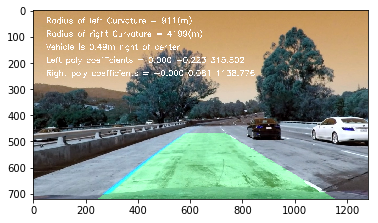

In [120]:
test1 = average_pipeline("test_images/test1.jpg", filepath=True)

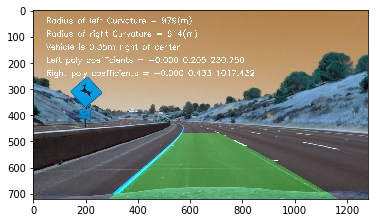

In [121]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0
test2 = average_pipeline("test_images/test2.jpg", filepath=True)

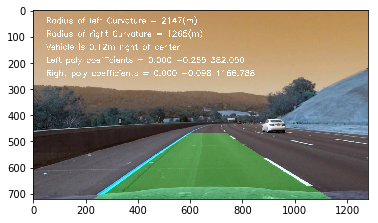

In [122]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0
test3 = average_pipeline("test_images/test3.jpg", filepath=True)

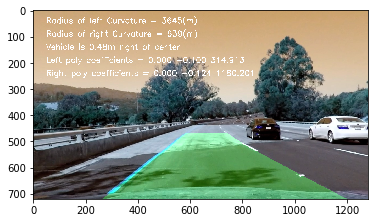

In [123]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0
test4 = average_pipeline("test_images/test4.jpg", filepath=True)

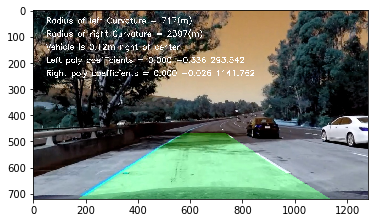

In [124]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0
test5 = average_pipeline("test_images/test5.jpg", filepath=True)

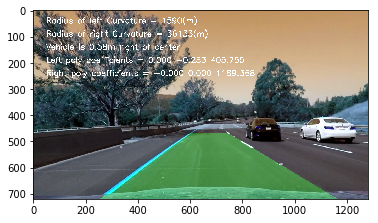

In [125]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0
test6 = average_pipeline("test_images/test6.jpg", filepath=True)

In [126]:
'''
################ III. video pipeline #####################

'''

'\n################ III. video pipeline #####################\n\n'

In [127]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [128]:
prev_left_fit = None # empty list
prev_right_fit = None
prev_left_curverad_pixel = 0
prev_right_curverad_pixel = 0

min_leftfitx = 0
max_leftfitx = 0
min_rightfitx = 0
max_rightfitx = 0
prev_gap_left = 0
prev_gap_right = 0

[MoviePy] >>>> Building video output_average_pipleline.mp4
[MoviePy] Writing video output_average_pipleline.mp4


 46%|████▌     | 576/1261 [03:57<04:26,  2.57it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  1855.95257439  >  68.8098279579


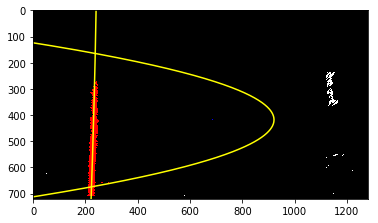

 prev_right_fit:  [ -8.63937369e-06   1.01913835e-01   1.11420153e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 58571.1914388
 ****** re-draw lanes : **** 


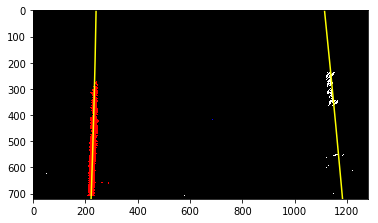

 49%|████▊     | 613/1261 [04:12<04:05,  2.64it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  283.038678926  >  69.6490757904


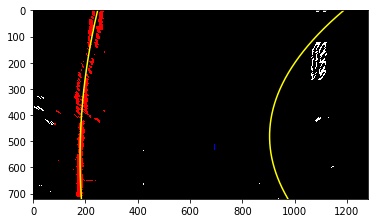

 prev_right_fit:  [  2.95407994e-04  -1.37917555e-01   1.11085375e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 1905.7636219
 ****** re-draw lanes : **** 


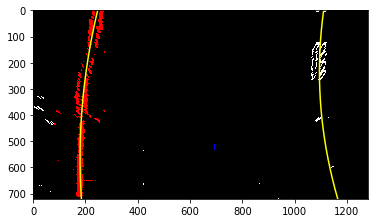

 49%|████▊     | 614/1261 [04:13<06:16,  1.72it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  3555.75413156  >  69.6490757904


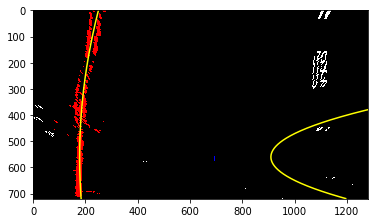

 prev_right_fit:  [  2.95407994e-04  -1.37917555e-01   1.11085375e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 1905.7636219
 ****** re-draw lanes : **** 


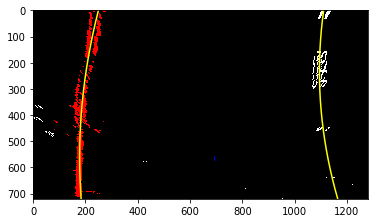

 49%|████▉     | 615/1261 [04:14<07:24,  1.45it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  3993.89517584  >  69.6490757904


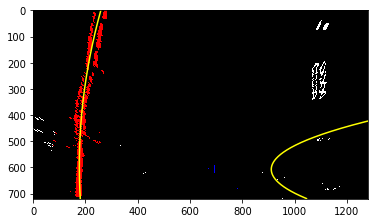

 prev_right_fit:  [  2.95407994e-04  -1.37917555e-01   1.11085375e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 1905.7636219
 ****** re-draw lanes : **** 


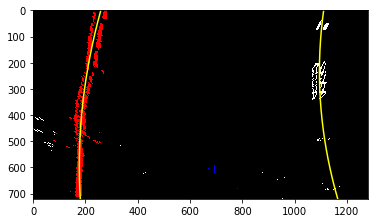

 49%|████▉     | 616/1261 [04:15<08:13,  1.31it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  5675.55895404  >  69.6490757904


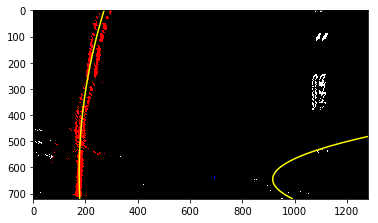

 prev_right_fit:  [  2.95407994e-04  -1.37917555e-01   1.11085375e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 1905.7636219
 ****** re-draw lanes : **** 


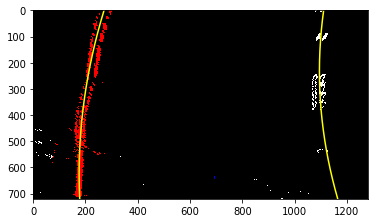

 79%|███████▉  | 1000/1261 [06:53<01:46,  2.45it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  6298.8562061  >  30.7985279663


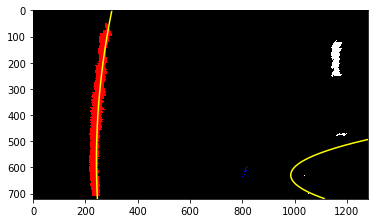

 prev_right_fit:  [  5.20964070e-05   5.37791002e-03   1.15254683e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 9690.55224602
 ****** re-draw lanes : **** 


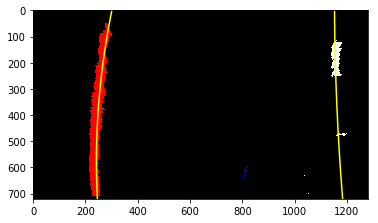

 79%|███████▉  | 1001/1261 [06:54<02:28,  1.76it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  3887.48961458  >  30.7985279663


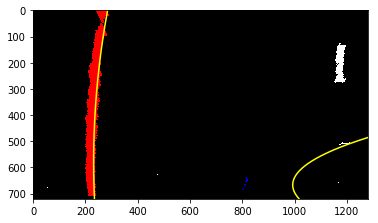

 prev_right_fit:  [  5.20964070e-05   5.37791002e-03   1.15254683e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 9690.55224602
 ****** re-draw lanes : **** 


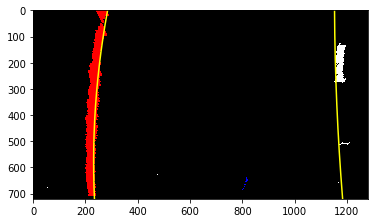

 79%|███████▉  | 1002/1261 [06:55<02:57,  1.46it/s]

 ****** use previous right coeff: **** 
 ****** gap_right is too larger than prev_gap_right: ****  1209.66470204  >  30.7985279663


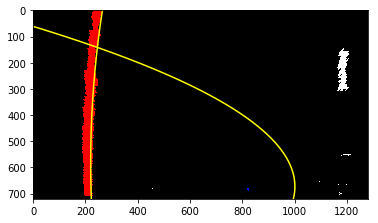

 prev_right_fit:  [  5.20964070e-05   5.37791002e-03   1.15254683e+03]
 ****** recalculate right_fitx **** 
 ****** recalculate right_curverad_pixel: **** 
right_curverad_pixel: 9690.55224602
 ****** re-draw lanes : **** 


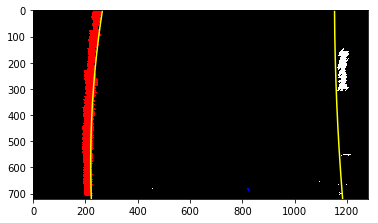

100%|█████████▉| 1260/1261 [08:41<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_average_pipleline.mp4 

CPU times: user 8min 37s, sys: 1min 29s, total: 10min 7s
Wall time: 8min 42s


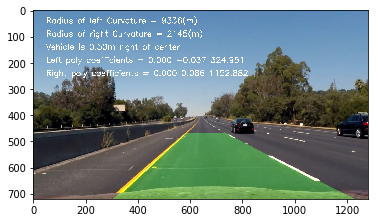

In [129]:
output = 'output_average_pipleline.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(average_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [130]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:

'''
################ IV. Discussion #####################

1, problem: needs manually try and set for x gradient and s color threshold

2, problem: for perspective transform, hard to find exact parallel lane pairs, also need to manualy set for destination
and source points from orginial and undistorted images, if choose unsymmetric source points from one undistored image, then 
for rest testing images this is not a good option, because other test images may miss to detect either left or right lane
within their birds-eye view !

3, from previous unperfectly parallel lanes I calculated out the radius of left and right lanes, since they are not paralel
in birds-eye view, both radius can differ 10 times ! this should exceed accepted range of proper lane radius.

4. from my generated output video, most time both lanes detected are matching the real lines, however under tree shadowing area,
when daylight is suddenly dark, I can see my detect lanes can suddenly jump into wired shapes. My detection system should be
more robust under sudden daylight changes !

solution: 
even though from 1261 frames extracted from given video, there are only 10 frames may freak out due to 2 place:
  when curv is huge and meanwhile there is sudden daylight change from shadowing. Therefore I saved previous frames parameters,
  and use the lane ranges in x direction to check, whether the lane is plotting out too sharply curved, which will result in
  a huge X direction expansion. e.g. previous right lane has min X pixel and max X pixel at ( 100, 150), so the gap distance is 50;
  the next frame may keep curve 

Updated: 
solution 1): use Markov assumption, to average previous frame and current frame, in case frame changes too much
solution 2): use S color + V color to better detect lanes
  
'''